In [1]:
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
import torch
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import torch
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset
import pandas as pd
import seaborn as sns

In [2]:
# Image transforms
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Path to dataset
data_dir = 'C:/Users/Омар/FinalAnalysis/AiFinal/.venv/dataset-resized'
batch_size = 32
num_classes = 6
seed = 42

In [4]:
# Load entire dataset temporarily (with dummy transform)
full_dataset = datasets.ImageFolder(root=data_dir, transform=transforms.ToTensor())

In [5]:
# Split dataset into train/val/test
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

In [6]:
torch.manual_seed(seed)
train_idx, valid_idx, test_idx = random_split(full_dataset, [train_size, valid_size, test_size])

In [7]:
# Reassign transforms per subset
train_set = Subset(datasets.ImageFolder(root=data_dir, transform=image_transforms['train']), train_idx.indices)
valid_set = Subset(datasets.ImageFolder(root=data_dir, transform=image_transforms['valid']), valid_idx.indices)
test_set  = Subset(datasets.ImageFolder(root=data_dir, transform=image_transforms['test']),  test_idx.indices)

In [8]:
# Create dataloaders
train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_data = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_data  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

In [9]:
print(f"Train: {len(train_set)}, Valid: {len(valid_set)}, Test: {len(test_set)}")
print(f"Classes: {full_dataset.classes}")

Train: 1768, Valid: 252, Test: 507
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [10]:
# Load model
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
loss_criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())


C:\Users\Омар\FinalAnalysis\AiFinal\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Омар\FinalAnalysis\AiFinal\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

epochs = 20
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()
    train_loss, train_acc = 0.0, 0.0
    loop = tqdm(train_data, desc="Training", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        train_acc += torch.sum(preds == labels).item()
        loop.set_postfix(loss=loss.item())

    train_losses.append(train_loss / len(train_data.dataset))
    train_accuracies.append(train_acc / len(train_data.dataset))

    # Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        loop = tqdm(valid_data, desc="Validating", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs.data, 1)
            val_acc += torch.sum(preds == labels).item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loop.set_postfix(loss=loss.item())

    val_losses.append(val_loss / len(valid_data.dataset))
    val_accuracies.append(val_acc / len(valid_data.dataset))

    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


Epoch 1/20


Val Loss: 0.8317, Val Accuracy: 0.7460

Epoch 2/20


Val Loss: 0.7118, Val Accuracy: 0.7460

Epoch 3/20


Val Loss: 0.6068, Val Accuracy: 0.8056

Epoch 4/20


Val Loss: 0.7219, Val Accuracy: 0.7460

Epoch 5/20


Val Loss: 0.5595, Val Accuracy: 0.8135

Epoch 6/20


Val Loss: 0.5545, Val Accuracy: 0.8333

Epoch 7/20


Val Loss: 0.6274, Val Accuracy: 0.8056

Epoch 8/20


Val Loss: 0.4960, Val Accuracy: 0.8452

Epoch 9/20


Val Loss: 0.5541, Val Accuracy: 0.8254

Epoch 10/20


Val Loss: 0.5451, Val Accuracy: 0.8095

Epoch 11/20


Val Loss: 0.6289, Val Accuracy: 0.7937

Epoch 12/20


Val Loss: 0.5427, Val Accuracy: 0.8373

Epoch 13/20


Val Loss: 0.4941, Val Accuracy: 0.8294

Epoch 14/20


Val Loss: 0.5146, Val Accuracy: 0.8333

Epoch 15/20


Val Loss: 0.5529, Val Accuracy: 0.8373

Epoch 16/20


Val Loss: 0.5526, Val Accuracy: 0.8254

Epoch 17/20


Val Loss: 0.5477, Val Accuracy: 0.8333

Epoch 18/20


Val Loss: 0.4843, Val Accuracy: 0.8413

Epoch 19/20


Val Loss: 0.5421, Val Accuracy: 0.8294

Epoch 20/20


Val Loss: 0.5471, Val Accuracy: 0.8413


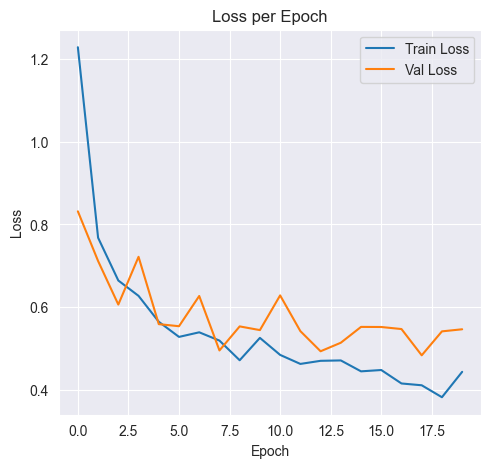

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

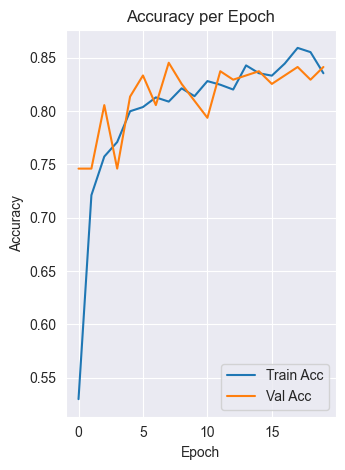

In [13]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.85      0.92      0.88        36
       glass       0.91      0.72      0.81        40
       metal       0.75      0.91      0.82        43
       paper       0.87      0.91      0.89        58
     plastic       0.88      0.85      0.86        60
       trash       0.70      0.47      0.56        15

    accuracy                           0.84       252
   macro avg       0.83      0.80      0.80       252
weighted avg       0.84      0.84      0.84       252



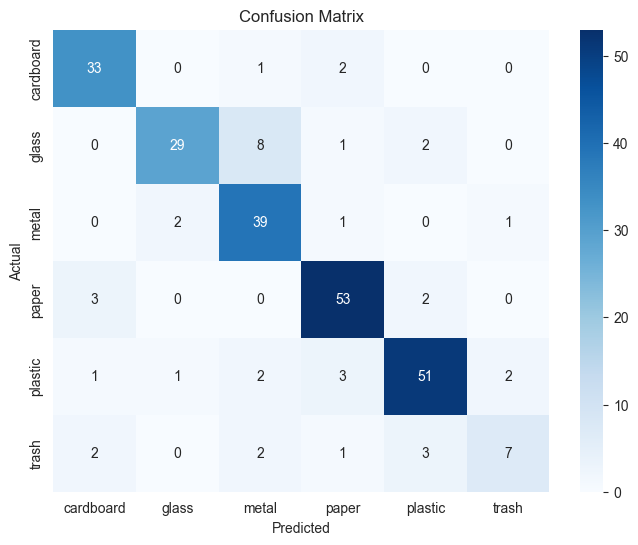

In [14]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

conf_matrix = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(conf_matrix, index=full_dataset.classes, columns=full_dataset.classes)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
# Ensure ASCII-safe and permission-safe path
model_dir = '..'
os.makedirs(model_dir, exist_ok=True)
filepath = os.path.join(model_dir, 'trashnet.pt')

In [16]:
# Save model
torch.save(model.state_dict(), filepath)
print(f"Model saved to {filepath}")

Model saved to ../..\trashnet.pt


In [17]:
# Define class names based on folder order in your dataset
class_names = [
    'cardboard',
    'glass',
    'metal',
    'paper',
    'plastic',
    'trash'
]

In [18]:
# Image transform (must match validation/test transform used in training)
image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [19]:
def predict(model, image_path):
    image = Image.open(image_path).convert("RGB")
    transformed = image_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed)
        _, predicted = torch.max(output, 1)
    return predicted.item(), image

In [20]:
def make_prediction(model_path, image_path):
    model = models.resnet50(pretrained=False)
    fc_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(fc_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 6),
        nn.LogSoftmax(dim=1)
    )

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    predicted_idx, original_image = predict(model, image_path)
    predicted_label = class_names[predicted_idx]

    # Show image with prediction
    plt.imshow(original_image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label

In [21]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

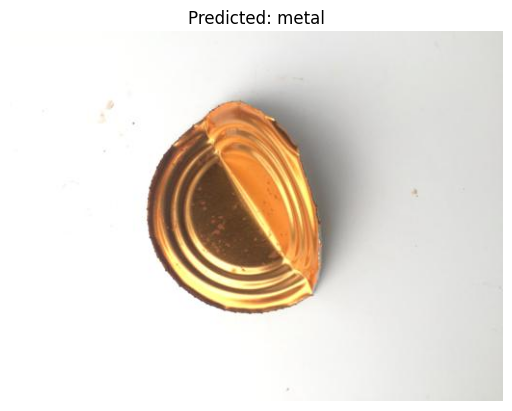

Predicted class: metal


In [45]:
# Entry point
if __name__ == '__main__':
    model_path = 'trashnet.pt'  # Adjust as needed
    image_path = '../../dataset-resized/metal/metal2.jpg'  # Replace with your test image path

    result = make_prediction(model_path, image_path)
    print("Predicted class:", result)